In [3]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# detector = MTCNN(image_size=224,device=device, post_process=False)


# MediaPipe

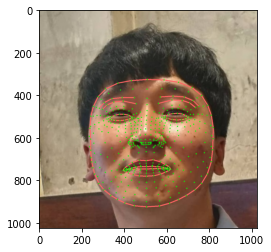

In [4]:
mp_drawing = mp.solutions.drawing_utils
point_drawing_spec = mp_drawing.DrawingSpec(thickness=4, circle_radius=1)
line_drawing_spec = mp_drawing.DrawingSpec(thickness=4, color=[255,100,100])

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5)

fm = {'fm' : face_mesh, 'ds':mp_drawing }

def mediapipe_infer(img, fm) :
    

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = fm['fm'].process(img)

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
        print("none")
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
            fm['ds'].draw_landmarks(
              image=annotated_image,
              landmark_list=face_landmarks,
              connections=mp_face_mesh.FACE_CONNECTIONS,
              landmark_drawing_spec=fm['ds'].DrawingSpec(thickness=4, circle_radius=1),
              connection_drawing_spec=fm['ds'].DrawingSpec(thickness=4, color=[255,100,100]))
    return annotated_image
    
img = cv2.imread('./myface.jpg',cv2.IMREAD_COLOR)
annotated_image = mediapipe_infer(img, fm)
plt.imshow(annotated_image)

# MTCNN torch version test

c:\users\quhb2\anaconda3\envs\torch-1.9\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(628, 458) (382, 167)


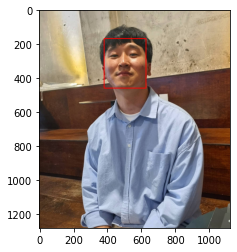

In [2]:
img = cv2.imread('./myface.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bbox, _ = detector.detect(img)
bbox = bbox[0].astype(np.int)

print((bbox[2],bbox[3]),(bbox[0],bbox[1]))

img = cv2.rectangle(img, (bbox[0],bbox[1]),(bbox[2],bbox[3]), (255,0,0), 3)
plt.imshow(img)

# Read and Write Video 

In [7]:
face_track = []
video_path = "multi_person_test.mp4"

cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_cnt = round(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)



out = cv2.VideoWriter('output.avi', fourcc, fps, (w, h))

cnt = 1
while True :
    
    ret, frame = cap.read()
    
    if ret :
        print(f"Complete [{cnt} / {frame_cnt}]",end="\r")
        cnt += 1
        
        bboxes, _ = detector.detect(frame)

        try :
            for bbox in bboxes :
                bbox = bbox.astype(np.int)
                frame = cv2.rectangle(frame, (bbox[0],bbox[1]),(bbox[2],bbox[3]), (255,0,0), 3)
    
            out.write(frame)
        except :
            continue
    else:
        break

cap.release()
out.release()

        

## Face Detector 성능

### MTCNN
    - 옆 모습 잘 못찾음
    - 정확도가 너무 떨어짐
    
### MediaPipe
    - 일단 성능은 보장됨.
    - mediapipe로 multi face landmark 가능한지 확인하기
    